## Analisis exploratorio de los datos

A continuacion, se hara un analisis exploratorio de los datos para verificar y asegurar la calidad e integridad los datos. Esto ayuda a establecer los procesos de transformacion requeridos en el ETL para entregar una informacion coherente y consistente. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [21]:
pays_source = pd.read_csv('../root/data/raw/pays.csv')
prints_source = pd.read_json('../root/data/raw/prints.json', lines=True)
taps_source = pd.read_json('../root/data/raw/taps.json', lines=True)

## Proceso de Limpieza de Datos

El proceso de limpieza de datos es esencial para asegurar la calidad y la integridad de los datos antes de realizar cualquier análisis. A continuación, se describen los pasos realizados para limpiar los datos:

### 1. Desanidamiento de Columnas

El desanidamiento de columnas es el proceso de aplanar estructuras de datos anidadas en columnas individuales. En este caso, se desanidaron las columnas `event_data` de los datasets `taps_source` y `prints_source` para obtener un formato más manejable.

In [22]:
def unnested_columns(taps_source, prints_source):
    taps_source = taps_source.join(taps_source['event_data'].apply(pd.Series))
    prints_source = prints_source.join(prints_source['event_data'].apply(pd.Series))

    taps_source = taps_source.drop(columns=['event_data'])
    prints_source = prints_source.drop(columns=['event_data'])
    
    return taps_source, prints_source

taps_source, prints_source = unnested_columns(taps_source, prints_source)

### 2. Conversión de Tipos de Datos

La conversión de tipos de datos es un paso crucial para asegurar que cada columna tenga el tipo de dato adecuado para su análisis. A continuación, se realizan las siguientes conversiones:

- `pay_date` en `pays_source` se convierte a tipo `datetime`.
- `user_id` en `pays_source`, `prints_desanidado` y `taps_desanidado` se convierte a tipo `str`.
- `day` en `prints_desanidado` y `taps_desanidado` se convierte a tipo `datetime`.
- `position` en `prints_desanidado` y `taps_desanidado` se convierte a tipo `int`.

Estas conversiones aseguran que los datos sean consistentes y estén en el formato correcto para el análisis posterior.

In [23]:
def convert_dtypes_standarized(pays_source, prints_source, taps_source):
    pays_source['pay_date'] = pd.to_datetime(pays_source['pay_date'])
    pays_source['user_id'] = pays_source['user_id'].astype(str)

    prints_source['user_id'] = prints_source['user_id'].astype(str)
    prints_source['day'] = pd.to_datetime(prints_source['day'])
    prints_source['position'] = prints_source['position'].astype(int)

    taps_source['user_id'] = taps_source['user_id'].astype(str)
    taps_source['day'] = pd.to_datetime(taps_source['day'])
    taps_source['position'] = taps_source['position'].astype(int)

    prints_source['value_prop'] = prints_source['value_prop'].str.lower().str.strip()
    taps_source['value_prop'] = taps_source['value_prop'].str.lower().str.strip()
    
    return pays_source, prints_source, taps_source

pays_source, prints_source, taps_source = convert_dtypes_standarized(pays_source, prints_source, taps_source)

### 4. Verificación de Valores Nulos

La verificación de valores nulos es crucial para identificar y manejar datos faltantes. Se utilizó el método `isnull().sum()` para contar los valores nulos en cada columna de los datasets desanidados y el dataset `pays_source`.

In [24]:
print(prints_source.isnull().sum())
print(taps_source.isnull().sum())
print(pays_source.isnull().sum())

day           0
user_id       0
position      0
value_prop    0
dtype: int64
day           0
user_id       0
position      0
value_prop    0
dtype: int64
pay_date      0
total         0
user_id       0
value_prop    0
dtype: int64


### 5. Verificación de Valores Repetidos

La verificación de valores repetidos ayuda a identificar y eliminar duplicados que pueden sesgar los resultados del análisis. Se puede utilizar el método `duplicated()` para encontrar filas duplicadas en los datasets.

Estos pasos aseguran que los datos estén en un estado adecuado para el análisis posterior, mejorando la precisión y la fiabilidad de los resultados.


In [25]:
duplicados_pays = pays_source.duplicated().sum()
print(f"Filas duplicadas en pays_source: {duplicados_pays}")

duplicados_prints = prints_source.duplicated().sum()
print(f"Filas duplicadas en prints_desanidado: {duplicados_prints}")

duplicados_taps = taps_source.duplicated().sum()
print(f"Filas duplicadas en taps_desanidado: {duplicados_taps}")

Filas duplicadas en pays_source: 0
Filas duplicadas en prints_desanidado: 0
Filas duplicadas en taps_desanidado: 0



### 6. Verificación de rango de valores para position y pago total

Se hara un grafico de dispersion para la columna position para determinar cual es el rango de valores apropiado para tener en cuenta y poder detectar valores atipicos en los datos. Al hacer esto, se determina que el valor rango apropiado sera de 0 a 3. 

Para el caso de los pagos, de la fuente de pays, se hara un diagrama de dispersion box plot y un histograma que nos ayude a ver como se compartan la cantidad monetaria de pagos que se hacen. De aca, se concluye que si bien hay algunos outliers, estos estan dentro de los esperado al no ser mayor a 4 veces que el valor promedia y teniendo en cuenta que son valores monetarios. Para el caso de los valores donde el total es 0 (110), se dejara los datos bajo el supuesto que desde contexto de negocios, los pagos de 0 tienen sentido en caso de que se usen descuentos o vouchers. 

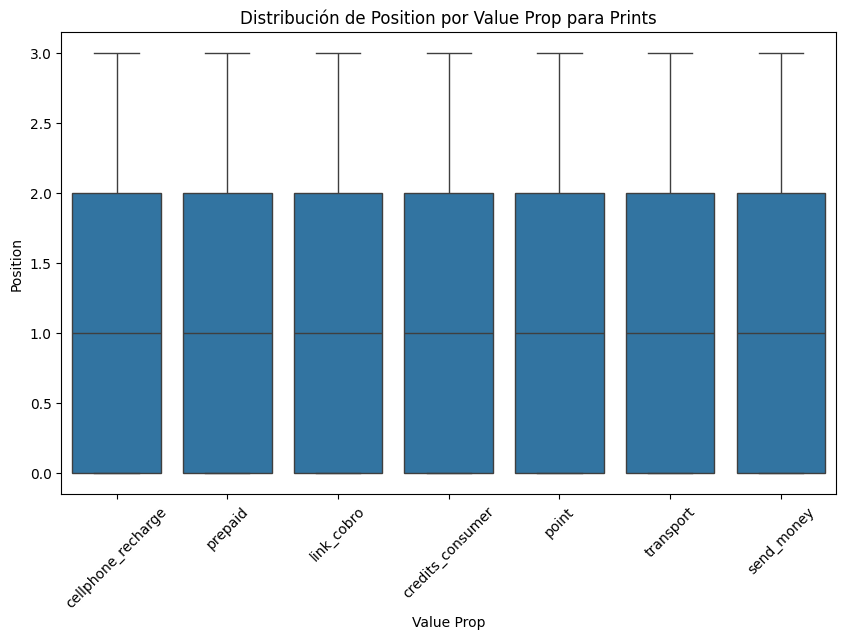

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='value_prop', y='position', data=prints_source)

plt.title('Distribución de Position por Value Prop para Prints')
plt.xlabel('Value Prop')
plt.ylabel('Position')

plt.xticks(rotation=45)

plt.show()

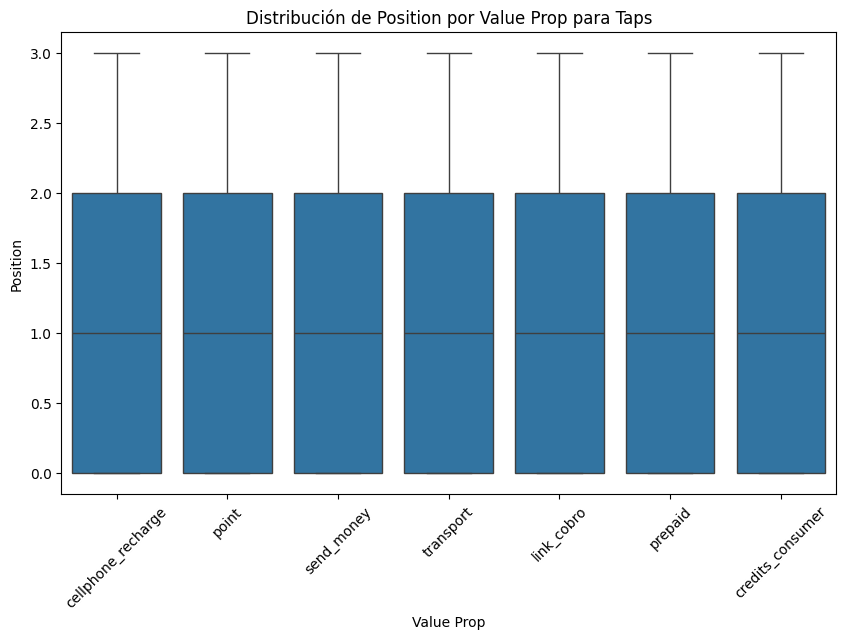

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='value_prop', y='position', data=taps_source)

plt.title('Distribución de Position por Value Prop para Taps')
plt.xlabel('Value Prop')
plt.ylabel('Position')

plt.xticks(rotation=45)

plt.show()

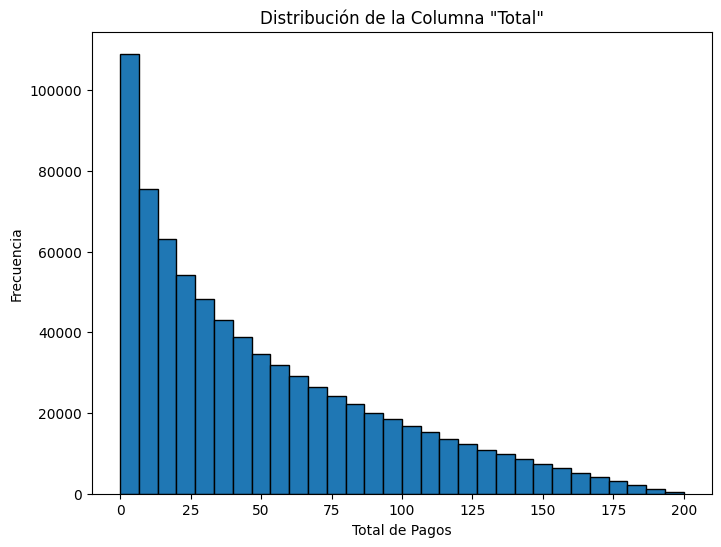

In [28]:
plt.figure(figsize=(8, 6))
plt.hist(pays_source['total'], bins=30, edgecolor='k')

plt.title('Distribución de la Columna "Total"')
plt.xlabel('Total de Pagos')
plt.ylabel('Frecuencia')

plt.show()

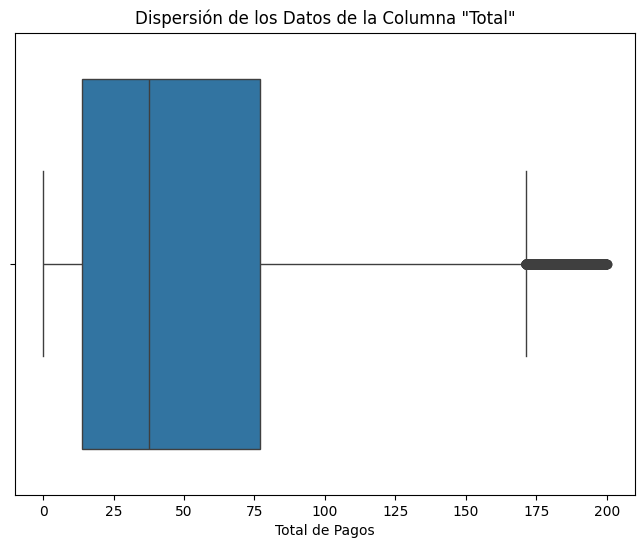

In [29]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=pays_source['total'])

plt.title('Dispersión de los Datos de la Columna "Total"')
plt.xlabel('Total de Pagos')

plt.show()

In [30]:
max_total = pays_source['total'].max()
min_total = pays_source['total'].min()
promedio_total = pays_source['total'].mean()

print(f"El valor máximo en la columna 'total' es: {max_total}")
print(f"El valor minimo en la columna 'total' es: {min_total}")
print(f"El valor promedio en la columna 'total' es: {promedio_total}")

El valor máximo en la columna 'total' es: 199.95
El valor minimo en la columna 'total' es: 0.0
El valor promedio en la columna 'total' es: 50.24577502733042


In [31]:
count_zero_or_negative = (pays_source['total'] <= 0).sum()
print(f"El número de veces que el valor en 'total' es igual o menor a cero es: {count_zero_or_negative}")

El número de veces que el valor en 'total' es igual o menor a cero es: 110


### 6. Conclusiones y filtros que se aplicarán al ETL

1. Se aplicará un aplanado de los datos anidados.
2. Se formatearán los datos acorde a los tipos de datos que representan. Tambien, se estandarizan el nombre de las categorias en value_prop.

## Implemenacion de transformacion de los datos
A continuacion, se hara la transformacion de datos necesarios para llegar dataset solicitado en el Expected Result.


#### Indicacion de clicks hechos en los prints de la ultima semana. 
1. Se toman los datos de la última semana de registros de prints.
2. Se extraen los datos de taps según las fechas obtenidas del filtro de prints.
3. Se realiza un merge entre ambas tablas, utilizando un indicador y las columnas user_id, day y value_prop como claves. Si el indicador muestra que se encontraron datos en ambas tablas, se considera como "clicked".



In [32]:
def transform_prints_clicked(prints_source, taps_source):
    fecha_min = prints_source['day'].max() - timedelta(weeks=1)
    fecha_max = prints_source['day'].max()

    prints_last_week = prints_source[prints_source['day'] >= fecha_min]

    taps_last_week = taps_source[(taps_source['day'] >= fecha_min) & (taps_source['day'] <= fecha_max)]

    print_clicked = pd.merge(prints_last_week, taps_last_week, on=['user_id', 'day', 'value_prop'], how='left', indicator=True)

    print_clicked['clicked'] = np.where(print_clicked['_merge'] == 'both', True, False)
    print_clicked = print_clicked.drop(columns=['_merge', 'position_y'])
    print_clicked = print_clicked.rename(columns={'position_x': 'position'})
    
    return print_clicked

print_clicked = transform_prints_clicked(prints_source, taps_source)

#### Obteniendo los valores acumulados. 
1. Se obtienen un arreglo de tuplas que contiene pares de fechas. Una fecha final que corresponde a una fecha unica en los prints clicked y otra que es 3 semanas posteriores a dicha fecha. 
2. Se ordenan los datos de taps, prints y pays para garantizar que las sumas acumuladas esten correctos. 
3. Se van generando dataframes para cada par de fechas y cada fuente (taps, prints y pays) para luego calcular sus valores acumulados. 
4. Se dejan solo los datos de la fecha final ya que solo nos interesa los datos acumulados hasta la fecha final. 
5. Se concatenan los resultados para cada par de tuplas con su respectiva fuente. 

In [33]:
def transform_accumulate_data(print_clicked, prints_source, taps_source, pays_source):
    valores_unicos_day = print_clicked['day'].unique()
    arreglo_tuplas = [(fecha, fecha - timedelta(weeks=3)) for fecha in valores_unicos_day]

    prints_source = prints_source.sort_values(by='day', ascending=True).reset_index(drop=True)
    taps_source = taps_source.sort_values(by='day', ascending=True).reset_index(drop=True)
    pays_source = pays_source.sort_values(by='pay_date', ascending=True).reset_index(drop=True)

    prints_3_prev_weeks_list = []
    taps_3_prev_weeks_list = []
    pays_3_prev_weeks_list = []

    for end_date, start_date in arreglo_tuplas:
        prints_3_prev_weeks = prints_source[(prints_source['day'] >= start_date) & (prints_source['day'] <= end_date)].copy()
        taps_3_prev_weeks = taps_source[(taps_source['day'] >= start_date) & (taps_source['day'] <= end_date)].copy()
        pays_3_prev_weeks = pays_source[(pays_source['pay_date'] >= start_date) & (pays_source['pay_date'] <= end_date)].copy()

        prints_3_prev_weeks['quantity_views_prev_print'] = prints_3_prev_weeks.groupby(['user_id', 'value_prop']).cumcount()
        taps_3_prev_weeks['quantity_clicked_prev_print'] = taps_3_prev_weeks.groupby(['user_id', 'value_prop']).cumcount()
        pays_3_prev_weeks['import_accumulates_prev_print'] = pays_3_prev_weeks.groupby(['user_id', 'value_prop'])['total'].cumsum()

        prints_3_prev_weeks = prints_3_prev_weeks[prints_3_prev_weeks['day'] == end_date]
        taps_3_prev_weeks = taps_3_prev_weeks[taps_3_prev_weeks['day'] == end_date]
        pays_3_prev_weeks = pays_3_prev_weeks[pays_3_prev_weeks['pay_date'] == end_date]

        prints_3_prev_weeks_list.append(prints_3_prev_weeks)
        taps_3_prev_weeks_list.append(taps_3_prev_weeks)
        pays_3_prev_weeks_list.append(pays_3_prev_weeks)

    prints_3_prev_weeks_cumulate = pd.concat(prints_3_prev_weeks_list, ignore_index=True)
    taps_3_prev_weeks_cumulate = pd.concat(taps_3_prev_weeks_list, ignore_index=True)
    pays_3_prev_weeks_cumulate = pd.concat(pays_3_prev_weeks_list, ignore_index=True)

    return prints_3_prev_weeks_cumulate, taps_3_prev_weeks_cumulate, pays_3_prev_weeks_cumulate

#### Unificacion de los datos. 
1. Se toman los dataframes generados para prints_clicked, prints_3_prev_weeks_cumulate, taps_3_prev_weeks_cumulate y taps_3_prev_weeks_cumulate
2. Se toman solo las columnas de interes y las columnas de prints_clicked.
3. Se llenan las celdas sin correspondencias con 0, en este caso hace sentido ya que representa que no se vio, no hizo click o no hizo importes, el cual es valido desde la perspectiva de negocio. 

In [34]:
def merge_data(print_clicked, prints_3_prev_weeks_cumulate, taps_3_prev_weeks_cumulate, pays_3_prev_weeks_cumulate):
    result = pd.merge(print_clicked, 
                      prints_3_prev_weeks_cumulate[['day', 'user_id', 'value_prop', 'quantity_views_prev_print']], 
                      on=['day', 'user_id', 'value_prop'], 
                      how='left')

    result = pd.merge(result, 
                      taps_3_prev_weeks_cumulate[['day', 'user_id', 'value_prop', 'quantity_clicked_prev_print']], 
                      on=['day', 'user_id', 'value_prop'], 
                      how='left')

    result = pd.merge(result, 
                      pays_3_prev_weeks_cumulate[['pay_date', 'user_id', 'value_prop', 'import_accumulates_prev_print']], 
                      left_on=['day', 'user_id', 'value_prop'], 
                      right_on=['pay_date', 'user_id', 'value_prop'], 
                      how='left')

    result = result.drop(columns=['pay_date'])
    
    result = result.fillna(0)
    
    return result

In [35]:
print_clicked = transform_prints_clicked(prints_source, taps_source)
prints_3_prev_weeks_cumulate, taps_3_prev_weeks_cumulate, pays_3_prev_weeks_cumulate = transform_accumulate_data(print_clicked, prints_source, taps_source, pays_source)
result = merge_data(print_clicked, prints_3_prev_weeks_cumulate, taps_3_prev_weeks_cumulate, pays_3_prev_weeks_cumulate)

In [36]:
result.head(15)

,day,user_id,position,value_prop,clicked,quantity_views_prev_print,quantity_clicked_prev_print,import_accumulates_prev_print
0,2020-11-23,69000,0,credits_consumer,False,0,0.0,98.59
1,2020-11-23,69000,1,link_cobro,False,0,0.0,152.51
2,2020-11-23,69000,2,transport,False,1,0.0,0.00
3,2020-11-23,69000,3,prepaid,False,0,0.0,0.00
4,2020-11-23,66521,0,prepaid,False,0,0.0,0.00
5,2020-11-23,66521,1,cellphone_recharge,False,1,0.0,0.00
6,2020-11-23,66521,2,credits_consumer,True,0,0.0,0.00
7,2020-11-23,66521,3,point,False,2,0.0,0.00
8,2020-11-23,65232,0,credits_consumer,False,0,0.0,0.00
9,2020-11-23,5810,0,cellphone_recharge,True,0,0.0,0.00
